# Car Object Detection AI

### For Google Colab Only - Don't run if running locally!!!

In [23]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd drive/MyDrive/AI Final Project

In [24]:
# pip install Keras-Applications

## Import Libraries

In [25]:
import os, time, random
from tqdm.auto import tqdm
import shutil as sh

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications import ResNet50

## Data Creation & Preprocessing

In [26]:
IMG_SIZE = 300
WIDTH = 676.0
HEIGHT = 380.0

Read csv label file

In [27]:
df = pd.read_csv('./data/train_solution_bounding_boxes.csv')
df['image'] = df['image'].apply(lambda x: x.split('.')[0])

1. Split training_imgaes into val and train
2. ./tmp/images have images and ./tmp/labels have xmin, ymin, xmax, ymax values

In [28]:
index = list(set(df.image))
val_index = index[0:len(index)//5] # [0:71]
for name,info in tqdm(df.groupby('image')):
    if name in val_index:
        save_path = 'val/'
    else:
        save_path = 'train/'
    if not os.path.exists('./tmp/labels/'+save_path):
        os.makedirs('./tmp/labels/'+save_path)
    with open('./tmp/labels/'+save_path+name+".txt", 'w+') as file:
        row = info[['xmin','ymin','xmax','ymax']].astype(float).values
        row = row.astype(str)
        for j in range(len(row)):
            text = ' '.join(row[j])
            file.write(text)
            file.write("\n")
    if not os.path.exists('./tmp/images/'+save_path):
        os.makedirs('./tmp/images/'+save_path)
    sh.copy("./data/training_images/{}.jpg".format(name),'./tmp/images/{}/{}.jpg'.format(save_path,name))

100%|██████████| 355/355 [00:00<00:00, 1065.15it/s]


### Create Training, Validation, and Test data

In [29]:
training_data = []
names = []

def create_training_data():
    for img in tqdm(os.listdir('./tmp/images/train/')):
        names.append(img[:-4])

    names.sort()
    for n in names:
        img_array = cv2.imread('./tmp/images/train/{}.jpg'.format(n))
        img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

        lbl_array = np.loadtxt('./tmp/labels/train/{}.txt'.format(n))
        lbl_array = np.array([lbl_array])

        training_data.append([img_array, lbl_array])

create_training_data()

100%|██████████| 355/355 [00:00<00:00, 3057449.53it/s]


In [30]:
val_data = []
names = []

def create_val_data():
    for img in tqdm(os.listdir('./tmp/images/val/')):
        names.append(img[:-4])

    for n in names:
        img_array = cv2.imread('./tmp/images/val/{}.jpg'.format(n))
        img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

        lbl_array = np.loadtxt('./tmp/labels/val/{}.txt'.format(n))
        lbl_array = np.array([lbl_array])

        val_data.append([img_array, lbl_array])

create_val_data()

100%|██████████| 324/324 [00:00<00:00, 2916211.36it/s]


In [31]:
np.random.shuffle(training_data)
np.random.shuffle(val_data)

Creating input for model

In [32]:
x_train = []
y_train  = []
y_temp = []

for features,label in training_data:
    y_shape = label[0].shape
    if(y_shape != (4,)):
        obj_num = label[0].shape[0]
        for i in range(obj_num):
            x_train.append(features)
            y_temp.append(label[0][i])
    else:
        x_train.append(features)
        y_temp.append(label[0])


for i in range(len(y_temp)):
    y_temp[i][0] = y_temp[i][0]/(WIDTH/IMG_SIZE)
    y_temp[i][1] = y_temp[i][1]/(HEIGHT/IMG_SIZE)
    y_temp[i][2] = y_temp[i][2]/(WIDTH/IMG_SIZE)
    y_temp[i][3] = y_temp[i][3]/(HEIGHT/IMG_SIZE)

x_train = np.array(x_train).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_train = np.array(y_temp)

In [33]:
x_val = []
y_val  = []
y_temp = []

for features,label in val_data:
    y_shape = label[0].shape
    if(y_shape != (4,)):
        obj_num = label[0].shape[0]
        for i in range(obj_num):
            x_val.append(features)
            y_temp.append(label[0][i])
    else:
        x_val.append(features)
        y_temp.append(label[0])

for i in range(len(y_temp)):
    y_temp[i][0] = y_temp[i][0]/(HEIGHT/IMG_SIZE)
    y_temp[i][1] = y_temp[i][1]/(WIDTH/IMG_SIZE)
    y_temp[i][2] = y_temp[i][2]/(HEIGHT/IMG_SIZE)
    y_temp[i][3] = y_temp[i][3]/(WIDTH/IMG_SIZE)

x_val = np.array(x_val).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_val = np.array(y_temp)

View Preprocessed images before going into model

[263.74819101 136.46235521 297.82923302 169.66698845]
[  0.         156.56978629  21.84996358 186.49206608]
[ 98.32483611 144.13455308 154.69774216 188.04647021]
[ 98.552822   156.53957526 127.64109985 177.00289579]
[  0.         155.40398313  43.48142753 191.93248058]


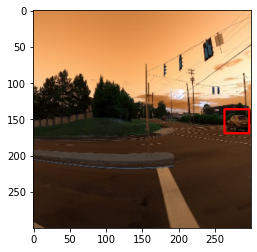

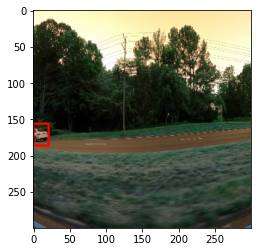

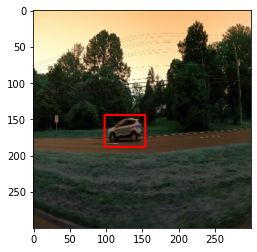

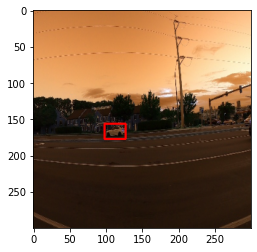

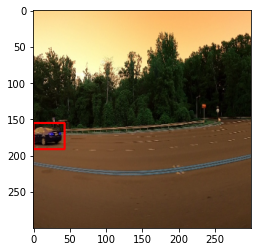

In [34]:
for i in range(5):
    color = (255,0,0)
    thickness = 2
    cv2.rectangle(x_train[i], (int(y_train[i][0]),int(y_train[i][1])), (int(y_train[i][2]),int(y_train[i][3])), color, thickness)
    plt.figure()
    plt.imshow(x_train[i])
    print(y_train[i])

## Training

### Create Model

In [35]:
resnet = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
flatten = Flatten()(resnet.output)
bboxHead = Dense(4)(flatten)

model = Model(inputs=resnet.input, outputs=bboxHead)

# model.summary()

model.compile(loss='mse', optimizer='adam',metrics=['accuracy'])

### Train Model

In [36]:
learning_rate = 0.001
batch_size = 16
num_epochs = 10

In [37]:
NAME = 'Car-Object-Detection-{}'.format(int(time.time()))
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs/{}'.format(NAME))
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=1)
model_save = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)

history = model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs, validation_data = (x_val, y_val), callbacks=[tensorboard, model_save])

# restore weights from the best training point
model.load_weights('best_model.h5')

scores = model.evaluate(x_train, y_train, verbose=0)
print('TRAINING SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

scores = model.evaluate(x_val, y_val, verbose=0)
print('\nVALIDATION SET\nLoss:', scores[0], '\nAccuracy:', scores[1])

Epoch 1/10


2022-04-27 04:26:26.929055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - ETA: 0s - loss: 5272.1733 - accuracy: 0.6780

2022-04-27 04:26:46.686491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 27s 670ms/step - loss: 5272.1733 - accuracy: 0.6780 - val_loss: 115711.1953 - val_accuracy: 0.1892
Epoch 2/10
35/35 [==============================] - 22s 612ms/step - loss: 2906.3267 - accuracy: 0.7442 - val_loss: 24749.7285 - val_accuracy: 0.5849
Epoch 3/10
35/35 [==============================] - 21s 587ms/step - loss: 2589.1729 - accuracy: 0.7692 - val_loss: 15961.6729 - val_accuracy: 0.5097
Epoch 4/10
35/35 [==============================] - 21s 609ms/step - loss: 2396.6106 - accuracy: 0.7657 - val_loss: 16247.2715 - val_accuracy: 0.6062
Epoch 5/10
35/35 [==============================] - 20s 585ms/step - loss: 2361.8218 - accuracy: 0.7746 - val_loss: 23145.7988 - val_accuracy: 0.2761
Epoch 6/10
35/35 [==============================] - 20s 582ms/step - loss: 2280.3403 - accuracy: 0.7746 - val_loss: 23444.3438 - val_accuracy: 0.2529
Epoch 7/10
35/35 [==============================] - 21s 602ms/step - loss: 2261.8679 - accuracy: 0.8014 - val_

## Prediction

In [38]:
def predict_random():
    testing_names = []
    for img in os.listdir('./data/testing_images'):
        testing_names.append(img)

    img_name = testing_names[random.randrange(0, len(testing_names))]
    filepath = './data/testing_images/{}'.format(img_name)

    raw_image = cv2.imread(filepath)
    raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
    img_array = cv2.resize(raw_image, (IMG_SIZE, IMG_SIZE))
    photo = img_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

    prediction = model.predict(photo)
    print(prediction[0])


    point1 = int(prediction[0][0]*(WIDTH/IMG_SIZE)-WIDTH/10),int(prediction[0][1]*(HEIGHT/IMG_SIZE)-HEIGHT/10)
    point2 = int(prediction[0][2]*(WIDTH/IMG_SIZE)+WIDTH/10), int(prediction[0][3]*(HEIGHT/IMG_SIZE)+HEIGHT/10)
    color = (255,0,0)
    thickness = 2

    cv2.rectangle(raw_image, point1, point2, color, thickness)
    plt.figure()
    plt.imshow(raw_image)

[165.62335 131.91833 212.15633 170.17642]
[137.34578 135.16437 179.5132  165.72171]
[106.23374 127.46052 150.84926 165.87085]
[177.6532  129.28345 240.39555 170.65181]
[141.07755  117.549614 185.38835  161.71326 ]
[125.824135 136.37836  175.14647  171.69077 ]
[210.23705 133.00273 263.00183 173.58365]
[141.6365  152.21286 186.39174 185.55745]
[ 79.39822  126.042755 131.78761  174.76534 ]
[107.79692 148.64575 163.30914 189.40547]


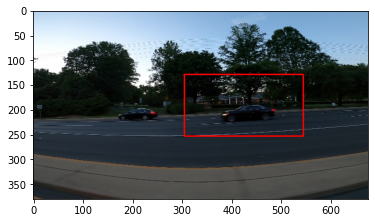

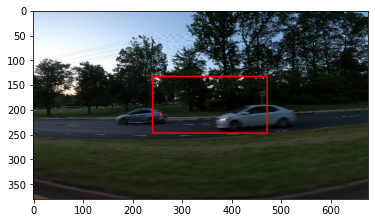

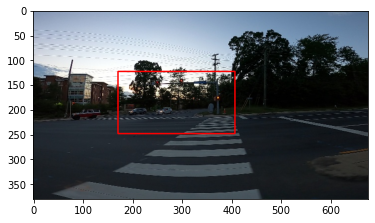

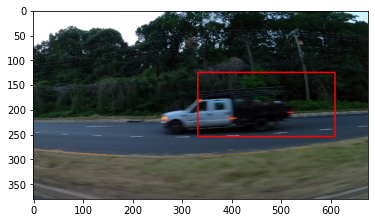

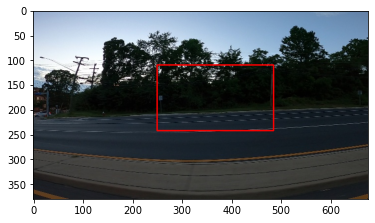

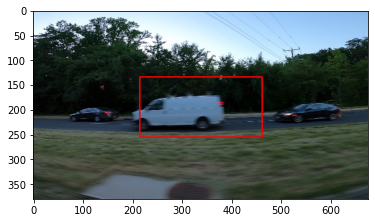

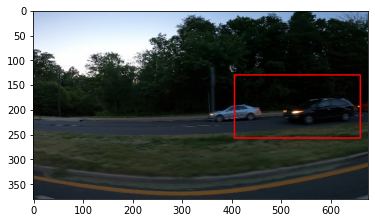

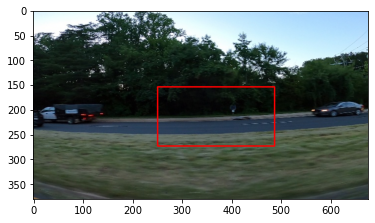

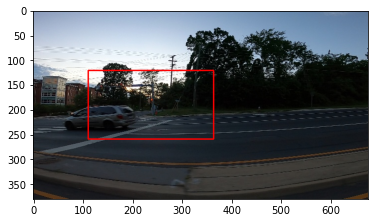

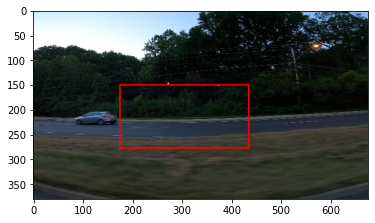

In [54]:
for i in range(10):
    predict_random()

In [40]:
def predict_path(file_path):
    raw_image = cv2.imread(file_path)
    img_array = cv2.resize(raw_image, (IMG_SIZE, IMG_SIZE))
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    photo = img_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

    prediction = model.predict(photo)
    print(prediction[0])

    point1 = int(prediction[0][0]), int(prediction[0][1])
    point2 = int(prediction[0][2]), int(prediction[0][3])
    color = (255,0,0)
    thickness = 2

    cv2.rectangle(img_array, point1, point2, color, thickness)
    plt.figure()
    plt.imshow(img_array)

[104.78498 128.61008 158.44746 169.96207]
[ 84.84309  114.319756 149.89815  168.31876 ]
[ 81.29016  105.759995 144.50627  158.0505  ]


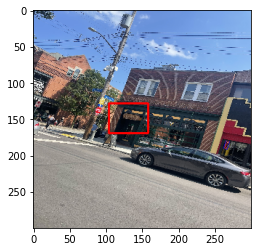

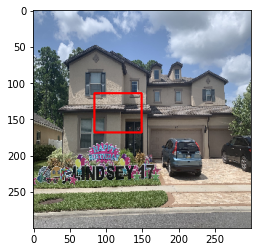

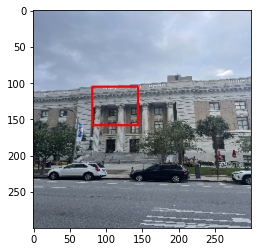

In [41]:
predict_path('./one.jpg')
predict_path('./two.jpg')
predict_path('./three.jpg')